In [5]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from itertools import product, combinations
from functools import partial
import matplotlib.pyplot as plt


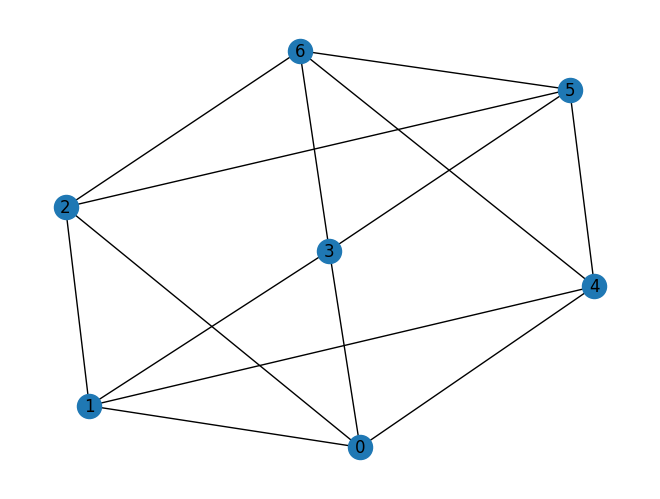

In [2]:
np.random.seed(1337)

n_side_nodes = 2
n_middle_nodes = 3

top_nodes = range(0, n_side_nodes)
middle_nodes = range(n_side_nodes, n_side_nodes + n_middle_nodes)
bottom_nodes = range(n_side_nodes + n_middle_nodes, n_middle_nodes + 2 * n_side_nodes)

top_edges = list(product(top_nodes, middle_nodes))
bottom_edges = list(product(middle_nodes, bottom_nodes))

graph = nx.Graph()
graph.add_edges_from(combinations(top_nodes, 2), color=0)
graph.add_edges_from(top_edges, color=0)
graph.add_edges_from(bottom_edges, color=1)
graph.add_edges_from(combinations(bottom_nodes, 2), color=1)

nx.draw_spring(graph, with_labels=True)

-5.485714285714286
0.5378151260504201
-0.29493087557603687
-0.6530612244897959
0.36571428571428577


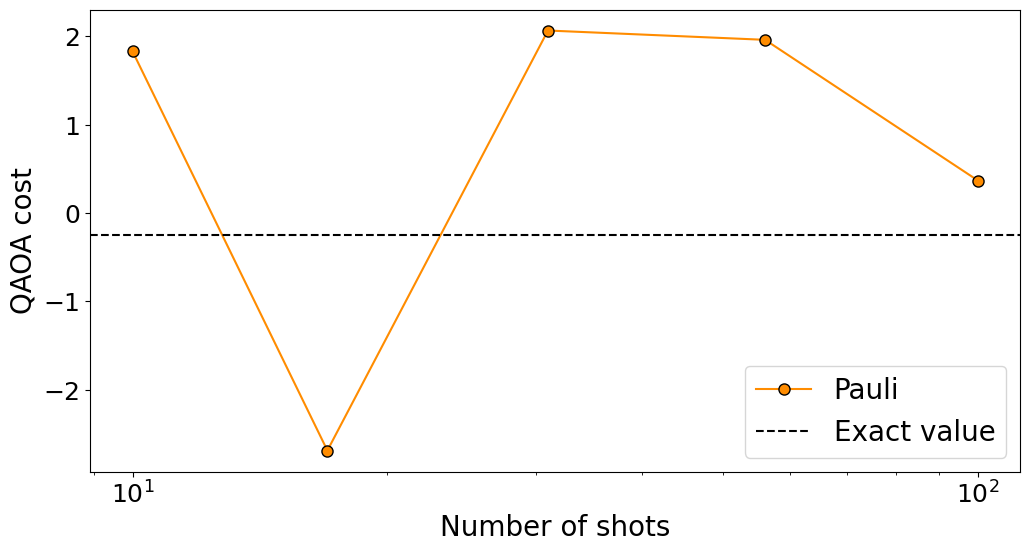

In [69]:
all_wires = list(range(len(graph)))

dev = qml.device("default.qubit", wires=5)


optimal_params = np.array([-0.240, 0.327])
optimal_cost = -0.248

def qaoa_template(params):

    gamma, beta = params

    for i in range(len(graph)):  # Apply the Hadamard gates
        qml.Hadamard(wires=i)

    for i, j in top_edges:

        # Apply the ZZ rotation gates
        # corresponding to the
        # green edges in the figure

        qml.MultiRZ(2 * gamma, wires=[i, j])

    qml.WireCut(wires=middle_nodes)  # Place the wire cut

    for i, j in bottom_edges:

        # Apply the ZZ rotation gates
        # corresponding to the
        # purple edges in the figure

        qml.MultiRZ(2 * gamma, wires=[i, j])

    for i in graph.nodes():  # Finally, apply the RX gates
        qml.RX(2 * beta, wires=i)

def qaoa_cost(bitstring):
    #print(bitstring)

    bitstring = np.atleast_2d(bitstring)
    # Make sure that we operate correctly on a batch of bitstrings

    z = (-1) ** bitstring[:, graph.edges()]  # Filter out pairs of bits correspondimg to graph edges
    costs = z.prod(axis=-1).sum(axis=-1)  # Do products and sums
    #print(np.squeeze(costs) / len(graph.edges))
    return np.squeeze(costs) / len(graph.edges)  # Normalize

@partial(qml.cut_circuit_mc, classical_processing_fn=qaoa_cost)
@qml.qnode(dev)
def qaoa(params):
    qaoa_template(params)
    return qml.sample(wires=all_wires)

n_shots = 50

shot_counts = np.logspace(1, 2, num=5, dtype=int, requires_grad=False)
pauli_cost_values = np.zeros_like(shot_counts, dtype=float)


for i, shots in enumerate(shot_counts):
    print(qaoa(optimal_params, shots=shots))
    pauli_cost_values[i] = qaoa(optimal_params, shots=shots)

fig, ax = plt.subplots(figsize=(12, 6))

ax.semilogx(
    shot_counts,
    pauli_cost_values,
    "o-",
    c="darkorange",
    ms=8,
    markeredgecolor="k",
    label="Pauli",
)

ax.axhline(optimal_cost, color="k", linestyle="--", label="Exact value")

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

ax.set_ylabel("QAOA cost", fontsize=20)
ax.set_xlabel("Number of shots", fontsize=20)

_ = ax.legend(frameon=True, loc="lower right", fontsize=20)

In [17]:
all_wires = list(range(len(graph)))

#dev = qml.device("default.qubit", wires=all_wires)
dev = qml.device("alicebob.qubit", alice_backend="EMU:40Q:LOGICAL_TARGET", wires=7, average_nb_photons=8, kappa_1=10, kappa_2=1e8, shots=100)

optimal_params = np.array([-0.240, 0.327])
optimal_cost = -0.248

def qaoa_template(params):

    gamma, beta = params

    for i in range(len(graph)):  # Apply the Hadamard gates
        qml.Hadamard(wires=i)

    for i, j in top_edges:

        # Apply the ZZ rotation gates
        # corresponding to the
        # green edges in the figure

        qml.MultiRZ(2 * gamma, wires=[i, j])

    qml.WireCut(wires=middle_nodes)  # Place the wire cut

    for i, j in bottom_edges:

        # Apply the ZZ rotation gates
        # corresponding to the
        # purple edges in the figure

        qml.MultiRZ(2 * gamma, wires=[i, j])

    for i in graph.nodes():  # Finally, apply the RX gates
        qml.RX(2 * beta, wires=i)

def qaoa_cost(bitstring):

    bitstring = np.atleast_2d(bitstring)
    # Make sure that we operate correctly on a batch of bitstrings

    z = (-1) ** bitstring[:, graph.edges()]  # Filter out pairs of bits correspondimg to graph edges
    costs = z.prod(axis=-1).sum(axis=-1)  # Do products and sums
    return np.squeeze(costs) / len(graph.edges)  # Normalize

@partial(qml.cut_circuit_mc, classical_processing_fn=qaoa_cost)
@qml.qnode(dev)
def qaoa(params):
    qaoa_template(params)
    return qml.sample(wires=all_wires)

n_shots = 50

shot_counts = np.logspace(1, 2, num=3, dtype=int, requires_grad=False)
pauli_cost_values = np.zeros_like(shot_counts, dtype=float)

for i, shots in enumerate(shot_counts):
    pauli_cost_values[i] = qaoa(optimal_params, shots=shots)

fig, ax = plt.subplots(figsize=(12, 6))

ax.semilogx(
    shot_counts,
    pauli_cost_values,
    "o-",
    c="darkorange",
    ms=8,
    markeredgecolor="k",
    label="Pauli",
)

ax.axhline(optimal_cost, color="k", linestyle="--", label="Exact value")

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

ax.set_ylabel("QAOA cost", fontsize=20)
ax.set_xlabel("Number of shots", fontsize=20)

_ = ax.legend(frameon=True, loc="lower right", fontsize=20)

Using alice & bob EMU:40Q:LOGICAL_TARGET backend...


KeyboardInterrupt: 

-270.57142857142856


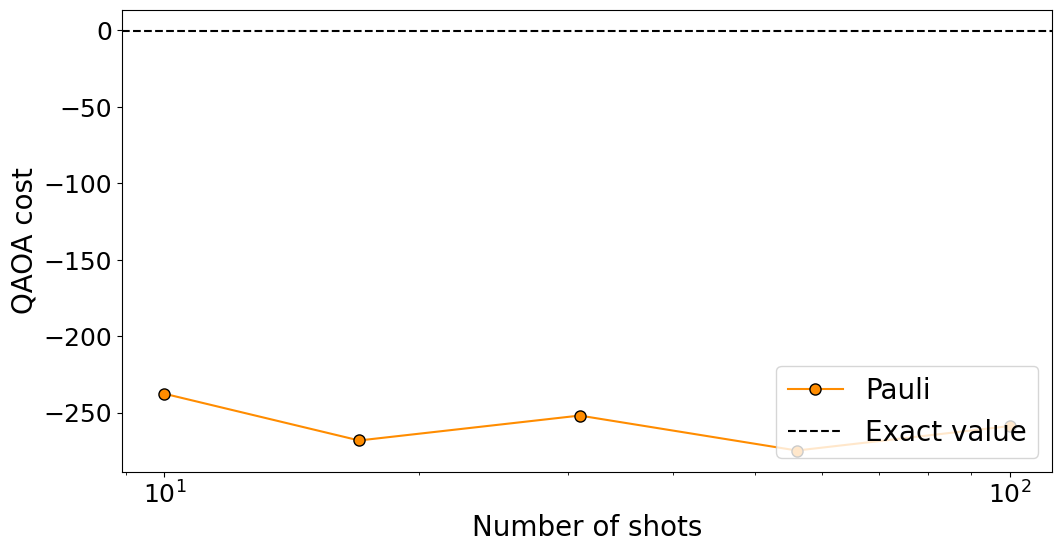

In [67]:
all_wires = list(range(len(graph)))

dev = qml.device("default.mixed", wires=8, shots=1000)


optimal_params = np.array([-0.240, 0.327])
optimal_cost = -0.248

def qaoa_template(params):

    gamma, beta = params

    for i in range(len(graph)):  # Apply the Hadamard gates
        qml.Hadamard(wires=i)

    for i, j in top_edges:

        # Apply the ZZ rotation gates
        # corresponding to the
        # green edges in the figure

        qml.MultiRZ(2 * gamma, wires=[i, j])

    qml.WireCut(wires=middle_nodes)  # Place the wire cut

    for i, j in bottom_edges:

        # Apply the ZZ rotation gates
        # corresponding to the
        # purple edges in the figure

        qml.MultiRZ(2 * gamma, wires=[i, j])

    for i in graph.nodes():  # Finally, apply the RX gates
        qml.RX(2 * beta, wires=i)

def qaoa_cost(bitstring):

    bitstring = np.atleast_2d(bitstring)
    # Make sure that we operate correctly on a batch of bitstrings

    z = (-1) ** bitstring[:, graph.edges()]  # Filter out pairs of bits correspondimg to graph edges
    costs = z.prod(axis=-1).sum(axis=-1)  # Do products and sums
    return np.squeeze(costs) / len(graph.edges)  # Normalize

#@partial(qml.cut_circuit_mc, classical_processing_fn=qaoa_cost)
@qml.qnode(dev)
def qaoa(params):
    qaoa_template(params)
    return qml.sample()

n_shots = 50

shot_counts = np.logspace(1, 2, num=5, dtype=int, requires_grad=False)
pauli_cost_values = np.zeros_like(shot_counts, dtype=float)


arr = []
for i in qaoa(optimal_params):
    #print(qaoa_cost(i))
    arr.append(qaoa_cost(i))


print(np.sum(arr))

for i, shots in enumerate(shot_counts):
    pauli_cost_values[i] = np.sum(qaoa_cost(qaoa(optimal_params)))

fig, ax = plt.subplots(figsize=(12, 6))

ax.semilogx(
    shot_counts,
    pauli_cost_values,
    "o-",
    c="darkorange",
    ms=8,
    markeredgecolor="k",
    label="Pauli",
)

ax.axhline(optimal_cost, color="k", linestyle="--", label="Exact value")

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

ax.set_ylabel("QAOA cost", fontsize=20)
ax.set_xlabel("Number of shots", fontsize=20)

_ = ax.legend(frameon=True, loc="lower right", fontsize=20)